<a href="https://colab.research.google.com/github/happyhillll/Medical-Report-Generation/blob/main/first_model_encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [2]:
from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("/content/drive/MyDrive/하울스 1팀 : medical report generation/Self Case Study 2")   

#ChexNet Model 
x-ray의 이미지 정보를 출력하기 위해 chexnet model 사용

In [4]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

#생성될 이미지 크기
image_shape= (224,224,3) #높이, 너비, 채널 = 이미지의 색상 정보 (3일 경우,다색 이미지)
image_input= Input(shape=(224,224,3))
base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

#사전학습된 모델
chexnet_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_2_features (InputLayer)  [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Chexnet_model (Functional)     (None, 1024)         7037504     ['image_1_features[0][0]',       
            

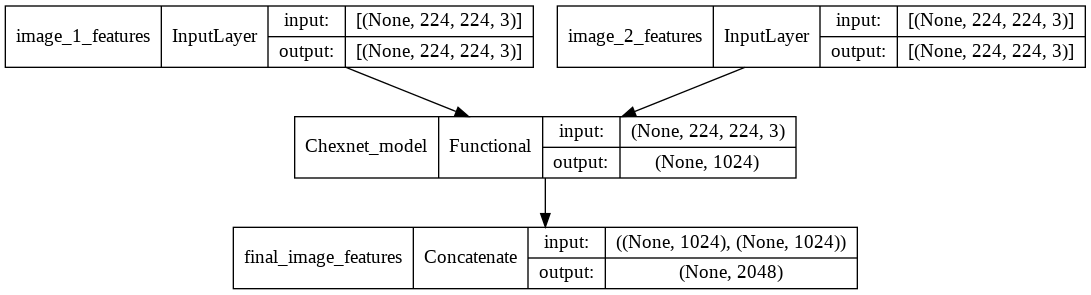

In [5]:
# 다 필요하지는 않음 --> 맨 뒤에서 2번째 것을 취함
final_chexnet_model = Model(inputs = chexnet_model.inputs, outputs = chexnet_model.layers[-2].output, name = "Chexnet_model")

# 환자 당 2개의 이미지 --> input도 2개
tf.keras.utils.plot_model(final_chexnet_model, show_shapes = True, show_layer_names = True, to_file="chex.png")

# 최종 이미지 추출
image_1 = Input(shape = (224,224,3), name = "image_1_features")
image_2 = Input(shape = (224,224,3), name = "image_2_features")
image_1_out = final_chexnet_model(image_1)
image_2_out = final_chexnet_model(image_2)
conc = concatenate((image_1_out, image_2_out),axis = -1, name = "final_image_features") #2개의 feature vector 연결
feature_extraction_model = Model(inputs = [image_1, image_2],outputs = conc)
feature_extraction_model.summary()

tf.keras.utils.plot_model(feature_extraction_model,show_shapes=True,show_layer_names=True)

In [6]:
#training 데이터와 test 데이터로 분리
data=pd.read_csv("data.csv")

train,test=train_test_split(data,test_size=0.2,random_state=1,shuffle=True)
print(train.shape) 
print(test.shape)

(3056, 5)
(764, 5)


In [7]:
print(train)

      Unnamed: 0  ...                                             report
2314        2314  ...  the heart normal size. the mediastinum stable....
2761        2761  ...  heart size normal. degenerative spurring thora...
2226        2226  ...  the lungs and pleural spaces show acute abnorm...
180          180  ...  compared prior chest radiograph from there has...
823          823  ...  the cardiac contours are normal. the lungs are...
...          ...  ...                                                ...
2763        2763  ...  the heart normal size and contour. the lungs a...
905          905  ...  increased interstitial lung changes with super...
1096        1096  ...  heart size normal. mediastinal silhouette and ...
235          235  ...  there are low lung volumes. the lungs are clea...
1061        1061  ...  the examination consists frontal and lateral r...

[3056 rows x 5 columns]


###feature extraction 모델을 이용하여 xray1,2에 해당하는 image feature 추출

In [8]:
'''
Obtaining the image feature for every patient using the feature extraction model which we had build earlier.
The output from this function is 2048 dimensiona vector for the x-ray set of every patient
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is given to the chexnet model for feature extraction
    
  image_feature=feature_extraction_model([image_1,image_2])
  
  return image_feature

In [9]:
train_features=[]
test_features=[]
for row in tqdm(range(train.shape[0])):  #train dataset의 길이만큼
  image_1=train.iloc[row]["image1"]
  image_2=train.iloc[row]["image2"]
  train_features.append(image_feature_extraction(image_1,image_2))
print("DONE")
for row in tqdm(range(test.shape[0])):
  image_1=test.iloc[row]["image1"] 
  image_2=test.iloc[row]["image2"]
  test_features.append(image_feature_extraction(image_1,image_2))

100%|██████████| 3056/3056 [41:17<00:00,  1.23it/s]


DONE


100%|██████████| 764/764 [09:02<00:00,  1.41it/s]


In [10]:
train["image_features"]=train_features
test["image_features"]=test_features
np.save("train_image_features",train_features)
np.save("test_image_features",test_features) 

# 데이터 셋 저장 *npz로 저장하려면 np.savez로 https://rfriend.tistory.com/358 참고
# np.save() --> 1개의 배열을 numpy format의 바이너리 파일(npy)로 저장
# np.savez() --> 여러 개의 배열을 1개의 압축되지 않은 .npz 포맷 파일로 저장

In [11]:
train_features=np.load("train_image_features.npz")
train_features=train_features['arr_0']
test_features=np.load("test_image_features.npz")
test_features=test_features['arr_0']
print(train_features.shape)

FileNotFoundError: ignored

In [ ]:
k=100
print(test_features[k])
one=test.iloc[k]["image1"] 
two=test.iloc[k]["image2"]
print(image_feature_extraction(one,two)) 

In [ ]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]

In [ ]:
print(train_report[0])
print(train_report[1])

In [ ]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('/content/drive/MyDrive/하울스 1팀 : medical report generation/Self Case Study 2/glove.6B.300d.txt', encoding = "UTF-8")
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 

In [ ]:
max_len=80

In [ ]:
#constructing the encoder-decoder model

#encoder model
input_1=Input(shape=(2048),name="Images")
encoder_out=Dense(512,activation="relu",name="enc_dense")(input_1)


#decoder model
input_text=Input(shape=(max_len),name="text")

embedding_out=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_text)

lstm_out= LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(embedding_out)

lstm_out= LSTM(units=512, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")(lstm_out) 

x=Dropout(0.5)(lstm_out)
add=tf.keras.layers.Add()([encoder_out, x])
  
x=Dense(512,kernel_initializer=tf.keras.initializers.he_normal(seed =1),activation="relu")(add)

x1=Dropout(0.25)(x)

x1=Dense(vocab_size,activation="softmax")(x1)
#encoder_decoder_model
encoder_decoder=Model(inputs=[input_1,input_text],outputs=x1)
encoder_decoder.summary()

In [ ]:
tf.keras.utils.plot_model(encoder_decoder,show_shapes=True,show_layer_names=True,to_file="model1.png") 

In [ ]:
batch_size=20

In [ ]:
#now we prepare the data set with the image fetaures and the reports
train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_report))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_report))
test_dataset = test_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 

In [ ]:
#printing the last batch of train dataset
for element in train_dataset:
  pass
print(element) 

In [ ]:
'''
Here we load the data to be tained. For each batch from train dataset, we prepare the data like:
for report1, image1 in each batch:
  report is tokenized
  input1= token of <sos>----> 
  output1=<token of next_word in report1>
  image=image1

  input2=token of <sos><token of second word in report1>
  output1=<token of third word>
  image=image1
  .
  .
  .

'''
def load_data(images,reports_unpadded):
    #images=tf.reshape(image,shape=(image.shape[0],image.shape[-1]))
    imgs = []
    input_reports = []
    output_reports = []
    #print(len(images))
    for i in range(len(images)):
      sequence=[] 
      for ele in reports_unpadded[i].split(" "):
        if ele in token.word_index.keys():
          sequence.append(token.word_index[ele])
      #  print(sequence)
      for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            
            
            out_seq = sequence[j]
            
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])
            
            input_reports.append(in_seq)
            
            output_reports.append(out_seq)
        
    return np.array(imgs), np.array(input_reports), np.array(output_reports)

In [ ]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
encoder_decoder.compile(optimizer="Adam", loss = maskedLoss)

In [ ]:
import datetime
import time

In [ ]:
# train_features=tf.reshape(train_features,shape=(train_features.shape[0],train_features.shape[-1]))
# test_features=tf.reshape(test_features,shape=(test_features.shape[0],test_features.shape[-1]))
# train_features.shape

In [ ]:
train_loss_list = []
test_loss_list=[]

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_train = 0
    batch_loss_test = 0
    
    for img, report in train_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)] # convert the tensor to array and then decode it 

        #for each set of elements in dataset prepare the data using load_data function
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        #padd the input so as to feed into the model
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        
        loss = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_train += loss

    train_loss = batch_loss_train/(len(train_report)//20)

    
    
    for img, report in test_dataset:
        
        r1 = [word.decode('utf-8') for word in np.array(report)]
        img_input, rep_input, output_word = load_data(img.numpy(), r1)
        rep_input = tf.keras.preprocessing.sequence.pad_sequences(rep_input, maxlen=80, padding='post')
        img_input=tf.reshape(img_input,shape=(img_input.shape[0],img_input.shape[-1]))
        loss = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_test += loss
    
    test_loss = batch_loss_test/(len(test_report)//20)
    

    train_loss_list.append(train_loss)

    test_loss_list.append(test_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, test_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.h5')


In [ ]:
encoder_decoder.load_weights('encoder_decoder_epoch_20.h5')  


In [ ]:
def evaluate(image1,image2):
    #Given the images from test data, we extract the bottleneck features from chexnet model
    image_features = image_feature_extraction(image1,image2)
    output_report=""
    
    #first word for the report is given as <sos>
    inp= "<sos>"

    image_features=tf.reshape(image_features,shape=(-1,image_features.shape[-1]))
    
    
    
    for i in range(max_len):
        #we find the list of tokens for the input word (already available words)
        list_of_tokens = [token.word_index[w] for w in inp.split()]

        #padd the available tokens to max_len
        input_padded = tf.keras.preprocessing.sequence.pad_sequences([list_of_tokens],max_len, padding='post')
        
        #we pass the image_features and the padded input to the enocoder decoder model and predict the next token
        predictions = encoder_decoder.predict([image_features,input_padded])
        
        #find the corresponding word and attach to the result
        arg = np.argmax(predictions[0]) 
        
        if token.index_word[arg]=="<eos>":
          
          output_report+=token.index_word[arg]+" "
          break
        else:
            
            output_report+=token.index_word[arg]+" "
            inp+= ' ' + token.index_word[arg]
        
    
    return output_report

In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  start=time.time()
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  start=time.time()
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  end=time.time()

  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("time taken for evaluation is ",end-start)
  print("*"*100)

 

In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)

In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)


In [ ]:
import random 
index=random.sample(range(test.shape[0]),3)

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)


In [ ]:
import random 
index=[100]

for i in index:
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
  i1=cv2.imread(img1)
  i2=cv2.imread(img2)
  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image1")
  plt.imshow(i1)
  plt.subplot(132)
  plt.title("image2")
  plt.imshow(i2)
  plt.show()
  #printing the actual and generated results
  result=evaluate(img1,img2) 
  actual=test_report[i]
  print("ACTUAL REPORT: ",actual)
  print("GENERATED REPORT: ",result) 
  print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
  print("*"*100)

In [ ]:
index=range(0,test.shape[0])
bl=0
start1=time.time()
for i in (index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result=evaluate(img1,img2) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)
end1=time.time() 
print("average bleu score on the test data is ",bl/test.shape[0])

In [ ]:
print('the average time taken for the evaluation is ',(end1-start1)/test.shape[0])